#Measurement of fitting time and query time

In this notebook different parameters and their influence to the fitting and query time of sklearn, lsh forest and minHash are examinded.

Import every needed dependency and create two functions for the creation of artificial datasets.

In [1]:
%matplotlib inline
import time
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import LSHForest
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
import neighbors as kneighbors
import random

from scipy.sparse import dok_matrix
from scipy.sparse import rand
from scipy.sparse import vstack

def create_dataset(seed=None,
                   number_of_centroids=None,
                   number_of_instances=None,
                   number_of_features=None,
                   size_of_dataset=None,
                   density=None,
                   fraction_of_density=None
                   ):
    dataset_neighborhood_list = []
    number_of_swapping_elements = int(number_of_features * density * fraction_of_density)
    y = []
    random_local = random.randint
    number_of_features_density = int(number_of_features*density)-1
    for k in xrange(number_of_centroids):
        dataset_neighbor = rand(1, number_of_features, density=density, format='lil', random_state=seed*k)
        nonzero_elements =  dataset_neighbor.nonzero()[1]
        for i in xrange(size_of_dataset):
            neighbor = dataset_neighbor.copy()
            # random.seed(seed*k)
            for j in xrange(number_of_swapping_elements):
                index = random_local(0, number_of_features_density)
                index_swap = random_local(0, number_of_features-1)
                neighbor[0, nonzero_elements[index]] = 0
                neighbor[0, index_swap] = 1
            dataset_neighborhood_list.append(neighbor)
        y.append(k)

    dataset_neighborhood = vstack(dataset_neighborhood_list)

    size_of_noise = number_of_instances-(number_of_centroids*size_of_dataset)
    if size_of_noise > 0:
            dataset_noise = rand(size_of_noise, number_of_features, format='lil', density=density, random_state=seed*seed)
            dataset = vstack([dataset_neighborhood, dataset_noise])
    else:
        dataset = vstack([dataset_neighborhood])
    random_value_generator = random.randint

    # add classes for noisy data
    for i in range(0, size_of_noise):
        y.append(random_value_generator(0, number_of_centroids))

    return csr_matrix(dataset), y

def create_dataset_fixed_nonzero(seed=None,
                   number_of_centroids=None,
                   number_of_instances=None,
                   number_of_features=None,
                   size_of_dataset=None,
                   non_zero_elements=None,
                   fraction_of_density=None):
    
    if (non_zero_elements > number_of_features):
        print "More non-zero elements than features!"
        return
    density = non_zero_elements / float(number_of_features)
    print "Desity:" , density
    dataset_neighborhood_list = []
    number_of_swapping_elements = int(non_zero_elements * fraction_of_density)
    y = []
    random_local = random.randint
    
    for k in xrange(number_of_centroids):
        dataset_neighbor = rand(1, number_of_features, density=density, format='lil', random_state=seed*k)
        nonzero_elements =  dataset_neighbor.nonzero()[1]
        for i in xrange(size_of_dataset):
            neighbor = dataset_neighbor.copy()
            # random.seed(seed*k)
            for j in xrange(number_of_swapping_elements):
                index = random_local(0, non_zero_elements-1)
                index_swap = random_local(0, number_of_features-1)
                neighbor[0, nonzero_elements[index]] = 0
                neighbor[0, index_swap] = 1
            dataset_neighborhood_list.append(neighbor)
        y.append(k)

    dataset_neighborhood = vstack(dataset_neighborhood_list)

    size_of_noise = number_of_instances-(number_of_centroids*size_of_dataset)
    if size_of_noise > 0:
            dataset_noise = rand(size_of_noise, number_of_features, format='lil', density=density, random_state=seed*seed)
            dataset = vstack([dataset_neighborhood, dataset_noise])
    else:
        dataset = vstack([dataset_neighborhood])
    random_value_generator = random.randint

    # add classes for noisy data
    for i in range(0, size_of_noise):
        y.append(random_value_generator(0, number_of_centroids))

    return csr_matrix(dataset), y


Function to measure and plot the performance for the given input data.
For the query times two methods are measured:
- All queries at once
- One query after another  
For example:
- For 50 queries kneighbors is called once with 50 instances to get all neighbors of these instances
- For 50 queries kneighbors is called 50 times with only one instance.

In [2]:
def measure_peformance( dataset, n_neighbors_sklearn = 5, n_neighbors_minHash = 5, size_of_query = 50):    
    time_fit_sklearn = []
    time_fit_minHash = []
    time_fit_lshf = []
    time_query_time_50_1_sklearn = []
    time_query_time_50_1_minHash_exact = []
    time_query_time_50_1_minHash_approx = []
    time_query_time_50_1_lshf = []

    time_query_time_1_50_sklearn = []
    time_query_time_1_50_minHash_exact = []
    time_query_time_1_50_minHash_approx = []
    time_query_time_1_50_lshf = []

    accuracy_1_50_lshf = []
    accuracy_1_50_minHash_exact = []
    accuracy_1_50_minHash_aprox = []
    
    centroids = 8
    size_of_datasets = 7

    for dataset_ in dataset:
        
        nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = n_neighbors_sklearn)
        nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(n_neighbors = n_neighbors_minHash)
        nearest_neighbor_lshf = LSHForest(n_estimators=20, n_candidates=200, n_neighbors=n_neighbors_minHash)
        
        time_start = time.time()
        nearest_neighbor_sklearn.fit(dataset_)
        time_end = time.time()
        time_fit_sklearn.append(time_end - time_start)

        time_start = time.time()
        nearest_neighbor_minHash.fit(dataset_)
        time_end = time.time()
        time_fit_minHash.append(time_end - time_start)

        time_start = time.time()
        nearest_neighbor_lshf.fit(dataset_)
        time_end = time.time()
        time_fit_lshf.append(time_end - time_start)
        
        if size_of_query < dataset_.shape[0]:
            query_ids = []
            for i in range(size_of_query):
                query_ids.append(random.randint(0, centroids * size_of_datasets))
            query = dataset_[query_ids]
        else:
            query = dataset_

        time_start = time.time()
        n_neighbors_sklearn_1_50 = nearest_neighbor_sklearn.kneighbors(query, return_distance=False)
        time_end = time.time()
        time_query_time_1_50_sklearn.append(time_end - time_start)

        time_start = time.time()
        n_neighbors_minHash_exact_1_50 = nearest_neighbor_minHash.kneighbors(query, return_distance=False)
        time_end = time.time()
        time_query_time_1_50_minHash_exact.append(time_end - time_start)
        

        time_start = time.time()
        n_neighbors_minHash_approx_1_50 = nearest_neighbor_minHash.kneighbors(query, fast=True, return_distance=False)
        time_end = time.time()
        time_query_time_1_50_minHash_approx.append(time_end - time_start)

        time_start = time.time()
        n_neighbors_lshf_1_50 = nearest_neighbor_lshf.kneighbors(query,return_distance=False)
        time_end = time.time()
        time_query_time_1_50_lshf.append(time_end - time_start)

        
        accuracy_1_50_lshf.append(np.in1d(n_neighbors_lshf_1_50, n_neighbors_sklearn_1_50).mean())
        accuracy_1_50_minHash_exact.append(np.in1d(n_neighbors_minHash_exact_1_50, n_neighbors_sklearn_1_50).mean())
        accuracy_1_50_minHash_aprox.append(np.in1d(n_neighbors_minHash_approx_1_50, n_neighbors_sklearn_1_50).mean())
    
    
        time_query_time_50_1_sklearn_loc = []
        time_query_time_50_1_sklearn_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_sklearn.kneighbors(query[i],return_distance=False)
            time_end = time.time()
            time_query_time_50_1_sklearn_loc.append(time_end - time_start)
        time_query_time_50_1_sklearn.append(np.sum(time_query_time_50_1_sklearn_loc))
        time_query_time_50_1_minHash_exact_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_minHash.kneighbors(query[i], return_distance=False)
            time_end = time.time()
            time_query_time_50_1_minHash_exact_loc.append(time_end - time_start)
        time_query_time_50_1_minHash_exact.append(np.sum(time_query_time_50_1_minHash_exact_loc))
        time_query_time_50_1_minHash_approx_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_minHash.kneighbors(query[i], fast=True,return_distance=False)
            time_end = time.time()
            time_query_time_50_1_minHash_approx_loc.append(time_end - time_start)
        time_query_time_50_1_minHash_approx.append(np.sum(time_query_time_50_1_minHash_approx_loc))
        time_query_time_50_1_lshf_loc = []
        for i in range(size_of_query):
            time_start = time.time()
            nearest_neighbor_lshf.kneighbors(query[i], return_distance=False)
            time_end = time.time()
            time_query_time_50_1_lshf_loc.append(time_end - time_start)
        time_query_time_50_1_lshf.append(np.sum(time_query_time_50_1_lshf_loc))
    return  (time_fit_sklearn, time_fit_minHash, time_fit_lshf, time_query_time_50_1_sklearn,
            time_query_time_50_1_minHash_exact, time_query_time_50_1_minHash_approx, 
            time_query_time_50_1_lshf, time_query_time_1_50_sklearn,
            time_query_time_1_50_minHash_exact, time_query_time_1_50_minHash_approx,
            time_query_time_1_50_lshf, accuracy_1_50_lshf,
            accuracy_1_50_minHash_exact, accuracy_1_50_minHash_aprox)

In [3]:
def plotData( data, color, label, title, xticks, ylabel,
             number_of_instances, number_of_features,
             figure_size=(10,5),  bar_width=0.1,log=True):
    plt.figure(figsize=figure_size)
    N = number_of_instances * number_of_features

    ind = np.arange(N)    # the x locations for the groups
    
    #"r", "b", "g", "c", "m", "y", "k", "w"
    count = 0
    for d, c, l in zip(data, color, label):
        plt.bar(ind + count * bar_width , d,   bar_width, color=c, label=l)
        count += 1
    if log:
        plt.yscale('log')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(ind+3*bar_width, (xticks))
    plt.legend(loc='upper left', fontsize='small')
    plt.show()

Measure the fitting time, query time and the accuracy of sklearn, lshf and minHash for the following parameters:
- seed = 6
- centroids = 8
- size_of_datasets = 7
- number_of_instances = [1000, 10000]
- number_of_features = [1000, 10000]
- density = 0.01
- fraction_of_density = 0.2
- n_neighbors_sklearn = 5
- n_neighbors_minHash = 5

In [11]:
seed = 6
centroids = 8
size_of_datasets = 7
number_of_instances = [1000, 10000]
number_of_features = [1000, 10000]
density = 0.01
fraction_of_density = 0.2
n_neighbors_sklearn = 5
n_neighbors_minHash = 5
dataset_array = []
for instances in number_of_instances:
    for features in number_of_features:
        dataset, y = create_dataset(seed=seed, number_of_centroids=centroids, number_of_instances=instances,
                                         number_of_features=features,density = density,
                                         fraction_of_density=fraction_of_density, size_of_dataset = size_of_datasets)
        dataset_array.append(dataset)

returnValues = measure_peformance(dataset_array, n_neighbors_sklearn, n_neighbors_minHash)

xticks = []
for i in number_of_instances:
    for j in number_of_features:
        tick = str(i)
        tick += "/"
        tick += str(j)
        xticks.append(tick)
# data, color, label, title, xticks, ylabel, number_of_instances, number_of_features,figure_size=(10,5),  bar_width=0.1,log=True
# plot query time for 50 times one query


####Query time for x queries in one query

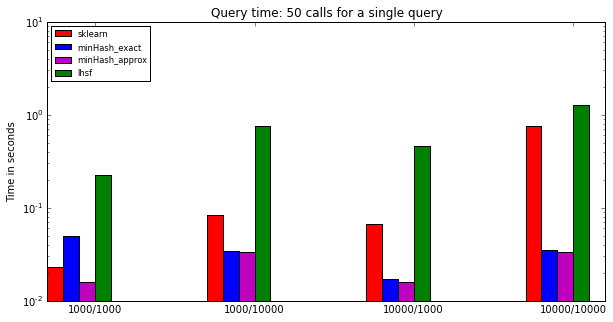

In [12]:
plotData(data=returnValues[3:7], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=xticks, ylabel="Time in seconds", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Query time: 50 calls for a single query')

####Query time for one time x queries

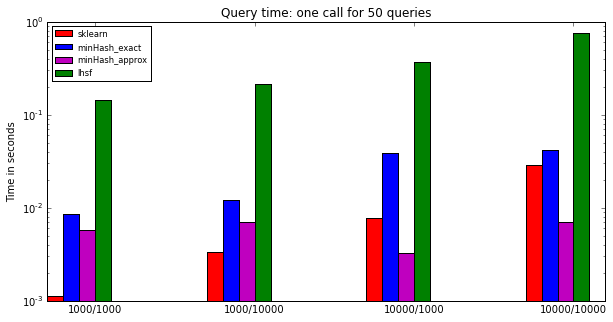

In [13]:
plotData(data=returnValues[7:11], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=xticks, ylabel="Time in seconds", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Query time: one call for 50 queries')

####Accuracy for different datasets

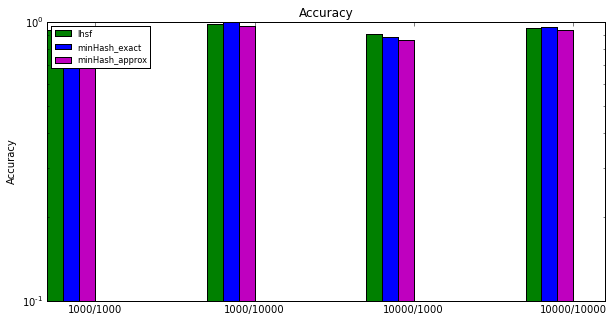

In [14]:
plotData(data=returnValues[11:], color=["g", "b", "m"], label=["lhsf", "minHash_exact", "minHash_approx"],
        xticks=xticks, ylabel="Accuracy", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Accuracy')

## Non-zero elements are fixed

For the dataset the following parameters are used:
- seed=5
- number_of_centroids=7,
- number_of_instances=[100]
- number_of_features=[int(1e3)]
- size_of_dataset=8
- non_zero_elements=10
- fraction_of_density=0.2
                 

In [15]:
number_of_instances = [100]
number_of_features = [int(1e3), int(1e4), int(1e5)]
dataset_array = []
for instances in number_of_instances:
    for features in number_of_features:
        dataset_fixed, y = create_dataset_fixed_nonzero(seed=5,
                   number_of_centroids=7,
                   number_of_instances=instances,
                   number_of_features=features,
                   size_of_dataset=8,
                   non_zero_elements=10,
                   fraction_of_density=0.2)
        dataset_array.append(dataset_fixed)
returnValuesNonZero = measure_peformance(dataset_array, n_neighbors_sklearn, n_neighbors_minHash)


Desity: 0.01
Desity: 0.001
Desity: 0.0001


####Query time: 50 calls for a single query

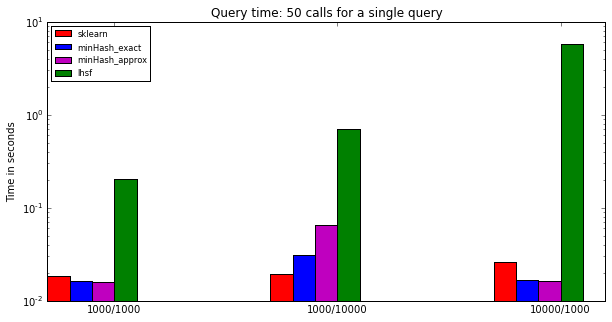

In [16]:
plotData(data=returnValuesNonZero[3:7], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=xticks, ylabel="Time in seconds", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Query time: 50 calls for a single query')

####Query time: one call for 50 queries

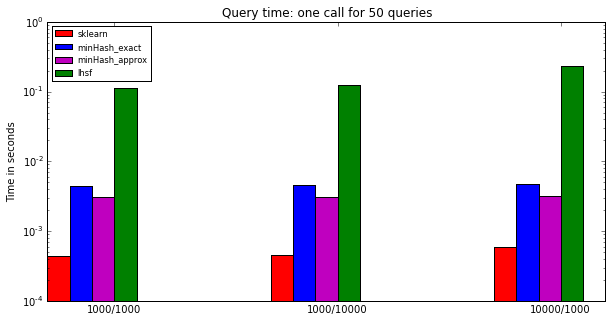

In [17]:
plotData(data=returnValuesNonZero[7:11], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=xticks, ylabel="Time in seconds", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Query time: one call for 50 queries')

####Accuracy for different datasets

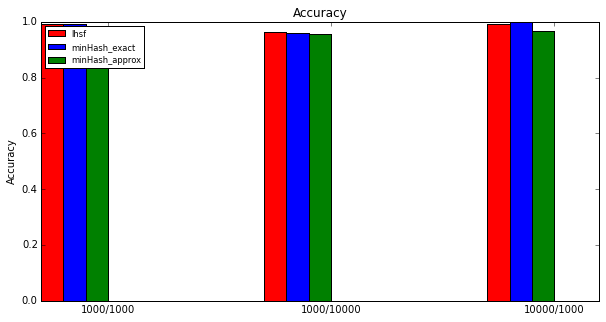

In [35]:
plotData(data=returnValuesNonZero[11:], color=["r", "b", "g"], label=["lhsf", "minHash_exact", "minHash_approx"],
        xticks=xticks, ylabel="Accuracy", number_of_instances=len(number_of_instances),
        number_of_features=len(number_of_features), title='Accuracy', log=False)

##Bursi dataset

In [4]:
from eden.converter.graph.gspan import gspan_to_eden
from eden.graph import Vectorizer
graphs = gspan_to_eden( 'http://www.bioinf.uni-freiburg.de/~costa/bursi.gspan' )
vectorizer = Vectorizer( r=2,d=5 )
datasetBursi = vectorizer.transform( graphs )

In [21]:
n_neighbors_sklearn = 5
n_neighbors_minHash = 5
returnValuesBursi = measure_peformance([datasetBursi], n_neighbors_sklearn, n_neighbors_minHash)

####Query time: 50 calls for a single query

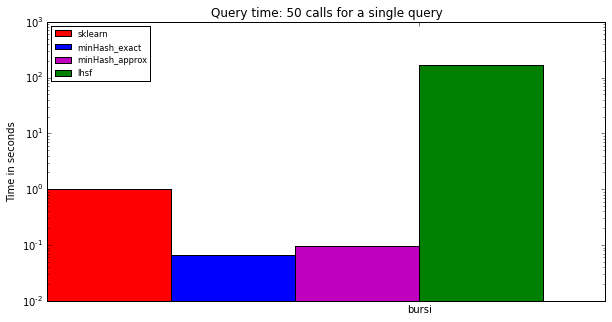

In [22]:
plotData(data=returnValuesBursi[3:7], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=["bursi"], ylabel="Time in seconds", number_of_instances=1,
        number_of_features=1, title='Query time: 50 calls for a single query')

####Query time: one call for 50 queries

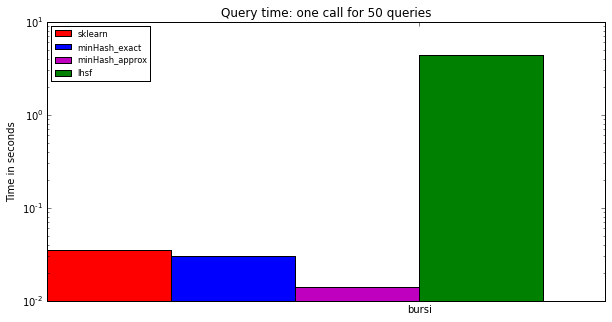

In [23]:
plotData(data=returnValuesBursi[7:11], color=["r", "b", "m", "g"], label=["sklearn", "minHash_exact", "minHash_approx", "lhsf"],
        xticks=["bursi"], ylabel="Time in seconds", number_of_instances=1,
        number_of_features=1, title='Query time: one call for 50 queries')

####Accuracy for different datasets

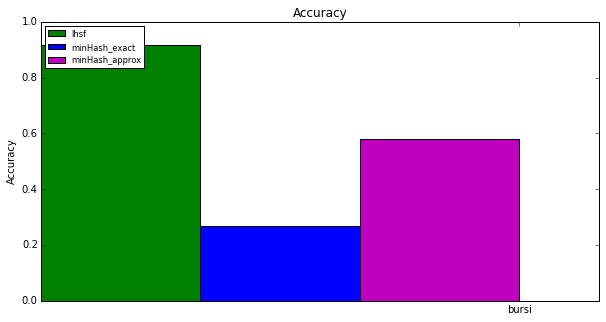

In [34]:
plotData(data=returnValuesBursi[11:], color=["g", "b", "m"], label=["lhsf", "minHash_exact", "minHash_approx"],
        xticks=["bursi"], ylabel="Accuracy", number_of_instances=1,
        number_of_features=1, title='Accuracy', log=False)

####Accuracy vs. number of hash functions

In [18]:
precision_minHash_exact = []
precision_minHash_approx = []
time_minHash_exact = []
time_minHash_approx = []
time_minHash_fit = []
size_of_query = 1000
query = None


if size_of_query < datasetBursi.shape[0]:
    query_ids = []
    for i in range(size_of_query):
        query_ids.append(random.randint(0, datasetBursi.shape[0]-1))
    query = datasetBursi[query_ids]
else:
    query = datasetBursi

nearest_neighbor_sklearn = NearestNeighbors(n_neighbors = 5)
nearest_neighbor_sklearn.fit(datasetBursi)
n_neighbors_sklearn = nearest_neighbor_sklearn.kneighbors(X=query,return_distance=False)

hash_functions_list = [50, 100, 200, 400, 800, 1600, 3200]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(n_neighbors = 5, number_of_hash_functions=hash_functions)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    # print nearest_neighbor_minHash._inverseIndex._inverse_index
    time_end = time.time()
    time_minHash_fit.append(time_end - time_start)

    time_start = time.time()
    n_neighbors_minHash_exact = nearest_neighbor_minHash.kneighbors(X=query,return_distance=False)
    time_end = time.time()
    time_minHash_exact.append(time_end - time_start)


    time_start = time.time()
    n_neighbors_minHash_approx = nearest_neighbor_minHash.kneighbors(X=query,fast=True,return_distance=False)
    # print n_neighbors_minHash_approx_1_50
    time_end = time.time()
    time_minHash_approx.append(time_end - time_start)


    accuracy_minHash_exact = np.in1d(n_neighbors_minHash_exact, n_neighbors_sklearn).mean()
    accuracy_minHash_approx = np.in1d(n_neighbors_minHash_approx, n_neighbors_sklearn).mean()
    precision_minHash_exact.append(accuracy_minHash_exact)
    precision_minHash_approx.append(accuracy_minHash_approx)
   
xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

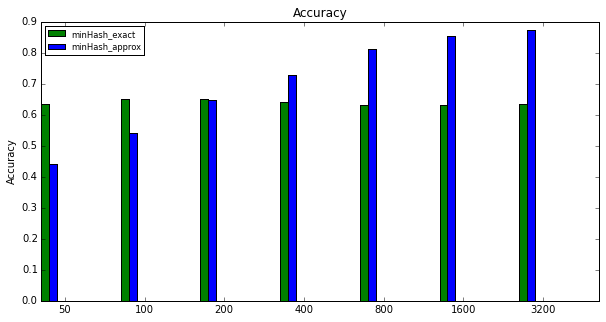

In [19]:
plotData(data=[precision_minHash_exact, precision_minHash_approx], color=["g", "b"], label=["minHash_exact", "minHash_approx"],
        xticks=xticksBursi, ylabel="Accuracy", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Accuracy', log=False)

####Test the fitting time of single-core vs. multi-core for different number of hash functions
As a dataset "bursi" is used.

In [46]:
import multiprocessing as mp
time_fit = []
time_fit_single_core = []
hash_functions_list = [100, 400, 600, 800, 1000]
for hash_functions in hash_functions_list:    

    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_hash_functions=hash_functions, number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(datasetBursi)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)

xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

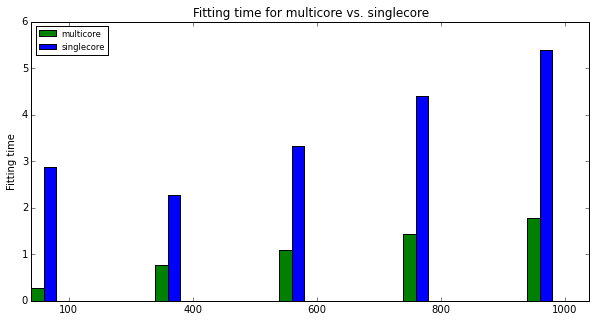

In [50]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', log=False)

####Test the fitting time of single-core vs. multi-core for datasets with different number of instances

In [8]:
import multiprocessing as mp

time_fit = []
time_fit_single_core = []
hash_functions_list = [100,1000,10000,100000]
for instances in hash_functions_list:    
    X, _ = create_dataset(seed=1,
                   number_of_centroids=7,
                   number_of_instances=instances,
                   number_of_features=1000,
                   size_of_dataset=8,
                   density=0.01,
                   fraction_of_density=0.2
                   )
    nearest_neighbor_minHash = kneighbors.MinHashNearestNeighbors(number_of_cores = mp.cpu_count())
    nearest_neighbor_minHash_single_core = kneighbors.MinHashNearestNeighbors(number_of_cores=1)

    time_start = time.time()
    nearest_neighbor_minHash.fit(datasetBursi)
    time_end = time.time()
    time_fit.append(time_end - time_start)
    
    time_start = time.time()
    nearest_neighbor_minHash_single_core.fit(datasetBursi)
    time_end = time.time()
    time_fit_single_core.append(time_end - time_start)
xticksBursi = []
for i in hash_functions_list:
    xticksBursi.append(str(i))

speedup = []
for i in xrange(len(time_fit)):
    speedup.append(time_fit_single_core[i]/  time_fit[i])

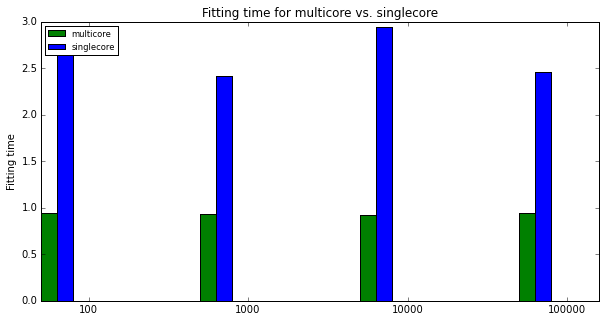

In [9]:
plotData(data=[time_fit, time_fit_single_core], color=["g", "b"], label=["multicore", "singlecore"],
        xticks=xticksBursi, ylabel="Fitting time", number_of_instances=len(hash_functions_list),
        number_of_features=1, title='Fitting time for multicore vs. singlecore', log=False)